# Lesson 3 project 2: Higgs analysis with combinatorics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import awkward as ak
import vector
from hist import Hist
vector.register_awkward()

In [ ]:
events = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")

<br><br><br>

## Exclusive and inclusive analysis

In [lesson-2-arrays/project-2-higgs.ipynb](../lesson-2-arrays/project-2-higgs.ipynb), you did an "exclusive" study of Higgs → ZZ → eeμμ. That is to say, the collision events weren't allowed to have anything else in them, such as another Z boson decaying into electrons or muons, a heavy-flavor quark decaying into electrons or muons, or stray particles misreconstructed as though they were electrons or muons. It's giving up on good events, but it's also excluding an unknown fraction of events if we don't have a way to estimate of how often these other phenomena occur in the same event.

<br>

With Awkward Array's combinatorial functions, we now have a way to do "inclusive" analyses.

In [ ]:
electron_pairs = ak.combinations(events.electron, 2)
muon_pairs = ak.combinations(events.muon, 2)

In [ ]:
two_electrons_and_two_muons = ak.cartesian([electron_pairs, muon_pairs])

The structure of `two_electrons_and_two_muons` is

```
array of lists of ((electron1, electron2), (muon1, muon2))
```

In [ ]:
two_electrons_and_two_muons.type.show()

<br>

How many `two_electrons_and_two_muons` (pairs of pairs) does each event have?

In [ ]:
ak.num(two_electrons_and_two_muons)

<br>

How many events have at least one of these combinations? (You could use the [ak.count_nonzero](https://awkward-array.org/doc/main/reference/generated/ak.count_nonzero.html) reducer or the [ak.sum](https://awkward-array.org/doc/main/reference/generated/ak.sum.html) reducer.)

In [ ]:
inclusive_candidates = ak.count_nonzero(ak.num(two_electrons_and_two_muons) > 0)
inclusive_candidates

<br>

How many events have exactly two electrons and exactly two muons?

In [ ]:
exclusive_candidates = ak.count_nonzero((ak.num(events.electron) == 2) & (ak.num(events.muon) == 2))
exclusive_candidates

<br>

More of the inclusive candidates than the exclusive candidates are not real Higgs → ZZ → eeμμ events (that's what quality cuts are for), but some of the

In [ ]:
inclusive_candidates / exclusive_candidates

times more candidates in the inclusive sample are real events.

Not knowing how many would prevent us from being able to measure absolute rates.

<br><br><br>

## Four electron (or four muon) final state

We can't construct candidates for Higgs → ZZ → eeee (or μμμμ) as we did with eeμμ because

In [ ]:
electron_pairs1 = ak.combinations(events.electron, 2)
electron_pairs2 = ak.combinations(events.electron, 2)
pairs_of_electron_pairs = ak.cartesian([electron_pairs1, electron_pairs2])

`pairs_of_electron_pairs` has slots for four electrons, but they're filled with electrons that may or may not be distinct.

<br>

Here's a more transparent example:

In [ ]:
array = ak.Array([[1, 2, 3, 4, 5]])

In [ ]:
pairs1 = ak.combinations(array, 2)
pairs2 = ak.combinations(array, 2)
pairs_of_pairs = ak.cartesian([pairs1, pairs2])

In [ ]:
pairs_of_pairs.to_list()

<br>

It should never be the case that an electron from the decay of one Z boson is also from the decay of the other Z boson.

<br>

Instead, we can use charge (+ or ‒) as we had previously used flavor (electron or muon). To do this, we'd have to put e⁺ into a different collection (array) from e⁻.

In [ ]:
eplus = events.electron[events.electron.charge > 0]
eminus = events.electron[events.electron.charge < 0]

In [ ]:
eplusplus = ak.combinations(eplus, 2)
eminusminus = ak.combinations(eminus, 2)
epairs_of_pairs = ak.cartesian([eplusplus, eminusminus])

<br>

These combinations were built entirely from distinct objects, so none of the particles within a candidate are duplicates.

Demonstrating with a more transparent example:

In [ ]:
array = ak.Array([[1, 2, 3, 4, 5]])

In [ ]:
evens = array[array % 2 == 0]
odds = array[array % 2 == 1]
evens, odds

In [ ]:
pairs1 = ak.combinations(evens, 2)
pairs2 = ak.combinations(odds, 2)
pairs_of_pairs = ak.cartesian([pairs1, pairs2])

In [ ]:
pairs_of_pairs.to_list()

<br>

Instead of using [ak.unzip](https://awkward-array.org/doc/main/reference/generated/ak.unzip.html), we can look at each of the slots individually. Tuples are records with fields named `"0"`, `"1"`, etc., so we can see that the first two slots always contain e⁺ and the last two slots always contain e⁻.

In [ ]:
assert ak.all(epairs_of_pairs["0", "0"].charge == 1)  # be sure to use quotation marks
assert ak.all(epairs_of_pairs["0", "1"].charge == 1)
assert ak.all(epairs_of_pairs["1", "0"].charge == -1)
assert ak.all(epairs_of_pairs["1", "1"].charge == -1)

<br>

The nested pairs are not the decay products of the two individual Z bosons, since each pair contains like-sign electrons.

In each candidate, there are two possible ways to assign electrons to Z bosons (two _interpretations_):

  1. $Z_1$'s electrons are in fields `"0", "0"` and `"1", "0"`, which would mean that $Z_2$'s electrons are in fields `"0", "1"` and `"1", "1"`.
  2. $Z_1$'s electrons are in fields `"0", "0"` and `"1", "1"`, which would mean that $Z_2$'s electrons are in fields `"0", "1"` and `"1", "0"`.

In [ ]:
interpretation1_z1 = epairs_of_pairs["0", "0"] + epairs_of_pairs["1", "0"]
interpretation1_z2 = epairs_of_pairs["0", "1"] + epairs_of_pairs["1", "1"]

interpretation2_z1 = epairs_of_pairs["0", "0"] + epairs_of_pairs["1", "1"]
interpretation2_z2 = epairs_of_pairs["0", "1"] + epairs_of_pairs["1", "0"]

<br>

For each candidate index `i`, either interpretation 1 is correct or interpretation 2 is correct. Different indexes `i` and `j` can have different interpretations.

As a reminder from [lesson-2-arrays/project-2-higgs.ipynb](../lesson-2-arrays/project-2-higgs.ipynb), the masses of Z → ee and Z → μμ looked like

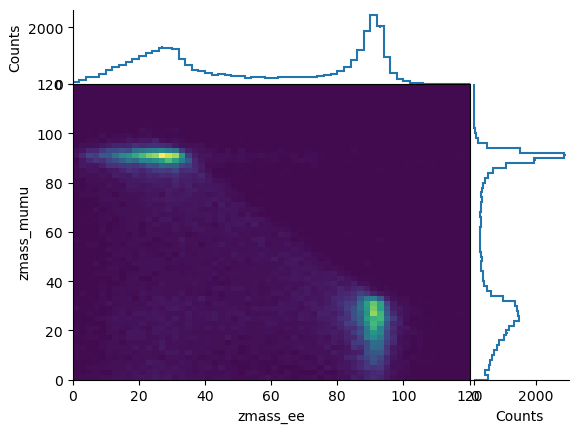

Since we didn't have any ambiguity about which particle to associate with each Z boson, the only thing to be determined was whether the Z → ee was close to being "on-shell" (mass close to 91 GeV/c$^2$) or the Z → μμ was close to being "on-shell."

<br>

The masses of the two e⁺e⁻ pairs in interpretation 1 are:

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_1").Regular(60, 0, 120, name="zmass_2").Double().fill(
    zmass_1=ak.flatten(interpretation1_z1.mass),
    zmass_2=ak.flatten(interpretation1_z2.mass),
).plot2d_full();

<br>

And the masses of the two e⁺e⁻ pairs in interpretation 2 are:

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_1").Regular(60, 0, 120, name="zmass_2").Double().fill(
    zmass_1=ak.flatten(interpretation2_z1.mass),
    zmass_2=ak.flatten(interpretation2_z2.mass),
).plot2d_full();

<br>

The "fog" of low-mass e⁺e⁻ pairs in each interpretation are from wrong-combinations. Put together two particles that don't come from the same decay and their mass will be a broad distribution of values.

The plots above also indicate how we can disambiguate interpretations, candidate-by-candidate. A good interpretation with have at least one Z boson close to its on-shell mass of 91 GeV/c$^2$.

## Exercise 1

Separately for `interpretation1_*` and for `interpretation2_*`, use [ak.where](https://awkward-array.org/doc/main/reference/generated/ak.where.html) to distinguish the biggest Z mass from the smallest Z mass.

In [ ]:
interpretation1_zsmall = ak.where(...)
interpretation1_zbig   = ak.where(...)

interpretation2_zsmall = ak.where(...)
interpretation2_zbig   = ak.where(...)

<br>

The masses of the lowest and highest e⁺e⁻ pair mass in interpretation 1 should look like:

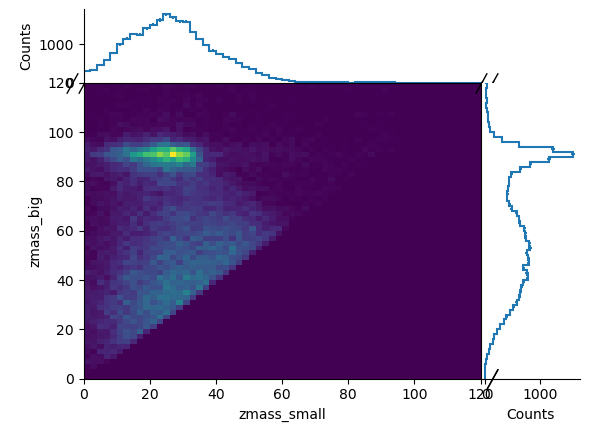

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(interpretation1_zsmall.mass),
    zmass_big=ak.flatten(interpretation1_zbig.mass),
).plot2d_full();

<br>

The masses of the lowest and highest e⁺e⁻ pair mass in interpretation 2 should look like:

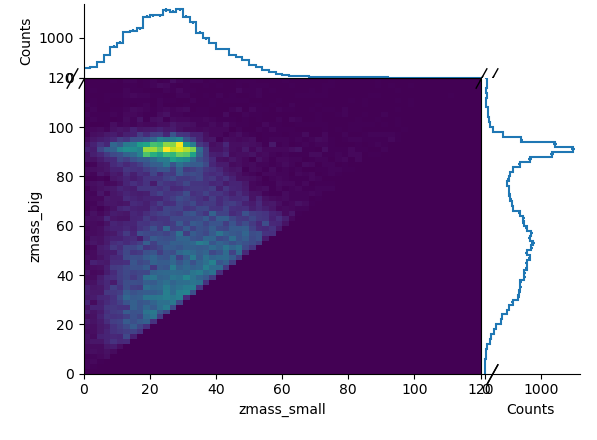

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(interpretation2_zsmall.mass),
    zmass_big=ak.flatten(interpretation2_zbig.mass),
).plot2d_full();

## Exercise 2

If one interpretation has a highest e⁺e⁻ pair mass close to the on-shell Z mass and the other doesn't, then it is the most likely interpretation.

Apply the `(12 < zmass_small) & (zmass_small < 120) & (40 < zmass_big) & (zmass_big < 120)` quality cuts and plot the Higgs mass, separately for each interpretation.

In [ ]:
interpretation1_quality = (
    ...
)
interpretation2_quality = (
    ...
)

The Higgs mass in interpretation 1 should look like:

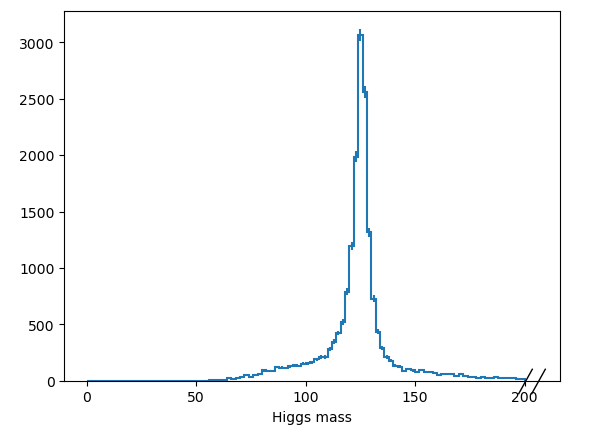

In [ ]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((interpretation1_zsmall + interpretation1_zbig).mass[interpretation1_quality])
).plot();

And the Higgs mass in interpretation 2 should look like:

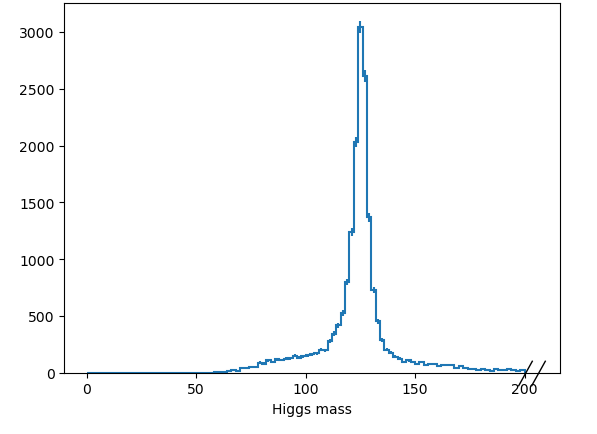

In [ ]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((interpretation2_zsmall + interpretation2_zbig).mass[interpretation2_quality])
).plot();

## Exercise 3

Just as we used [ak.where](https://awkward-array.org/doc/main/reference/generated/ak.where.html) to select between pair masses to find the lowest and highest per interpretation, we can select between interpretations on a candidate-by-candidate basis.

In [ ]:
from particle import Particle
from hepunits import GeV

onshell_mass = Particle.from_name("Z0").mass / GeV
onshell_mass

In [ ]:
interpretation1_is_best = ...

In [ ]:
best_interpretation_zbig = ak.where(interpretation1_is_best, interpretation1_zbig, interpretation2_zbig)
best_interpretation_zsmall = ak.where(interpretation1_is_best, interpretation1_zsmall, interpretation2_zsmall)

We are left with only one plot of the two Z bosons, in the best interpretation per candidate.

The pair of Z masses in this best interpretation should look like:

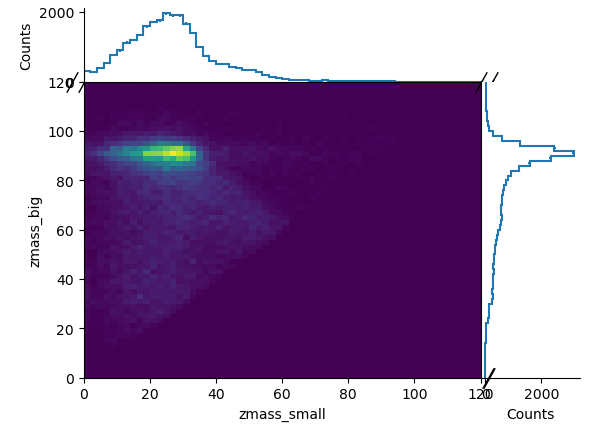

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(best_interpretation_zsmall.mass),
    zmass_big=ak.flatten(best_interpretation_zbig.mass),
).plot2d_full();

## Exercise 4

Even though we have selected the best Z-to-electron-pair matching for each group of 4 electrons, we still have multiple (or zero) groups of 4 electrons per event.

In [ ]:
best_interpretation_zbig

Use the same criteria, namely that the Higgs candidate in which the highest-mass Z boson is nearly on shell, to find the best Higgs candidate per event. The [ak.min](https://awkward-array.org/doc/main/reference/generated/ak.min.html) function with `axis=-1` replaces lists with their minimum value and empty lists with `None`:

In [ ]:
array_of_int = ak.Array([
    [3, 1, 5, 2],
    [2, 2, -4, 1],
    [],
    [3, 7, 4]
])
ak.min(array_of_int, axis=-1)

And the [ak.argmin](https://awkward-array.org/doc/main/reference/generated/ak.argmin.html) function with `axis=-1` and `keepdims=True` can be used to produce indexes to slice one array by the minimum of another.

In [ ]:
array_of_str = ak.Array([
    ["three", "one", "five", "two"],
    ["two", "two", "minus four", "one"],
    [],
    ["three", "seven", "four"]
])

In [ ]:
indexes = ak.argmin(array_of_int, axis=-1, keepdims=True)
indexes

In [ ]:
array_of_str[indexes]

In [ ]:
array_of_str[indexes][:, 0]

Use this technique to find the Higgs candidate in each event whose highest-mass Z boson has the closest to an on shell mass.

In [ ]:
best_higgs_candidate_index = ak.argmin(..., axis=-1, keepdims=True)
best_higgs_candidate_index

In [ ]:
best_higgs_zbig = best_interpretation_zbig[best_higgs_candidate_index][:, 0]
best_higgs_zsmall = best_interpretation_zsmall[best_higgs_candidate_index][:, 0]

best_higgs_zbig

We are left with only one pair of Z bosons per event. ([ak.flatten](https://awkward-array.org/doc/main/reference/generated/ak.flatten.html) with `axis=0` removes the `None` values.)

In [ ]:
Hist.new.Regular(60, 0, 120, name="zmass_small").Regular(60, 0, 120, name="zmass_big").Double().fill(
    zmass_small=ak.flatten(best_higgs_zsmall.mass, axis=0),
    zmass_big=ak.flatten(best_higgs_zbig.mass, axis=0),
).plot2d_full();

It should look like:

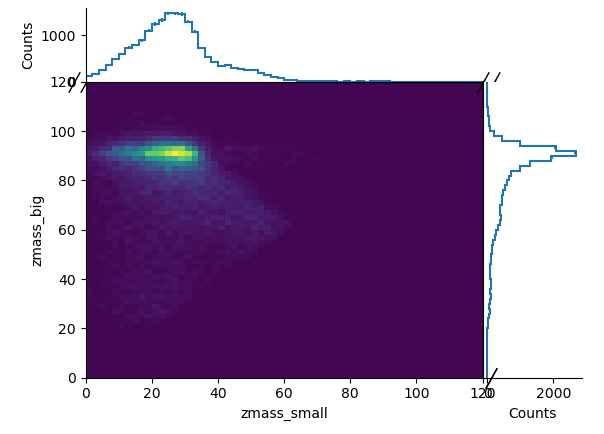

## Exercise 5

Now apply the quality cut to the best interpretation to get a final Higgs mass plot. Ignore the `None` values; they pass through this cut.

In [ ]:
best_interpretation_quality = (
    ...
)

It should look like:

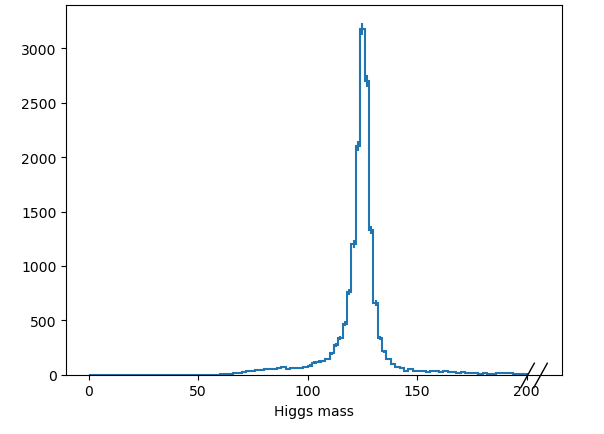

In [ ]:
Hist.new.Regular(100, 0, 200, name="Higgs mass").Double().fill(
    ak.flatten((best_higgs_zsmall + best_higgs_zbig).mass[best_interpretation_quality], axis=0)
).plot();